In [23]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings

# Show charts when running kernel
init_notebook_mode(connected=True)

# Turn off warnings
import warnings
warnings.simplefilter('ignore')

# Yahoo finance API
import yfinance as yf

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [24]:
# Get the data of the stock AAPL 
df = yf.download('AAPL','2012-01-01','2022-01-01') 
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.591937,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.659604,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.800154,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.933965,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.913448,394024400


In [25]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.index,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.update_layout(
    title='The Apple Stock price',
    yaxis_title='AAPL Stock',
    shapes = [dict(
        x0='2020-15-06', x1='2020-15-06', y0=0, y1=0.67, xref='x', yref='paper',
        line_width=2)],
    annotations=[dict(
        x='2020-01-03', y=0.67, xref='x', yref='paper',
        showarrow=False, xanchor='left', text='Increase Period Begins')]
)

fig.add_trace(go.Scatter(x=df.index,
                         y=df.Volume,
                         mode='lines',
                         name='Volume',
                         line=dict(color="#55ccff")), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(height=960, width=960)
fig.show()

In [26]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Open,2517.0,4.902000e+01,3.869000e+01,13.86,2.367000e+01,3.238000e+01,5.415000e+01,1.811200e+02
High,2517.0,4.953000e+01,3.916000e+01,14.27,2.391000e+01,3.264000e+01,5.488000e+01,1.821300e+02
Low,2517.0,4.852000e+01,3.825000e+01,13.75,2.342000e+01,3.208000e+01,5.346000e+01,1.785300e+02
Close,2517.0,4.904000e+01,3.873000e+01,13.95,2.367000e+01,3.238000e+01,5.401000e+01,1.803300e+02
Adj Close,2517.0,4.728000e+01,3.937000e+01,12.13,2.125000e+01,2.958000e+01,5.233000e+01,1.803300e+02
Volume,2517.0,2.150839e+08,1.758608e+08,41000000.00,1.031623e+08,1.512652e+08,2.652272e+08,1.506120e+09


In [27]:
df_close = df.Close.copy()
df_close.head(5)

Date
2012-01-03    14.686786
2012-01-04    14.765714
2012-01-05    14.929643
2012-01-06    15.085714
2012-01-09    15.061786
Name: Close, dtype: float64

ADfuller test to determine is data stationary?

In [28]:
from statsmodels.tsa.stattools import adfuller 

result = adfuller(df_close)
print('p-value: {0}'.format(result[1]))

p-value: 1.0


In [29]:
from pmdarima.arima.utils import ndiffs
print('d:',ndiffs(df_close, test='adf'))

d: 1


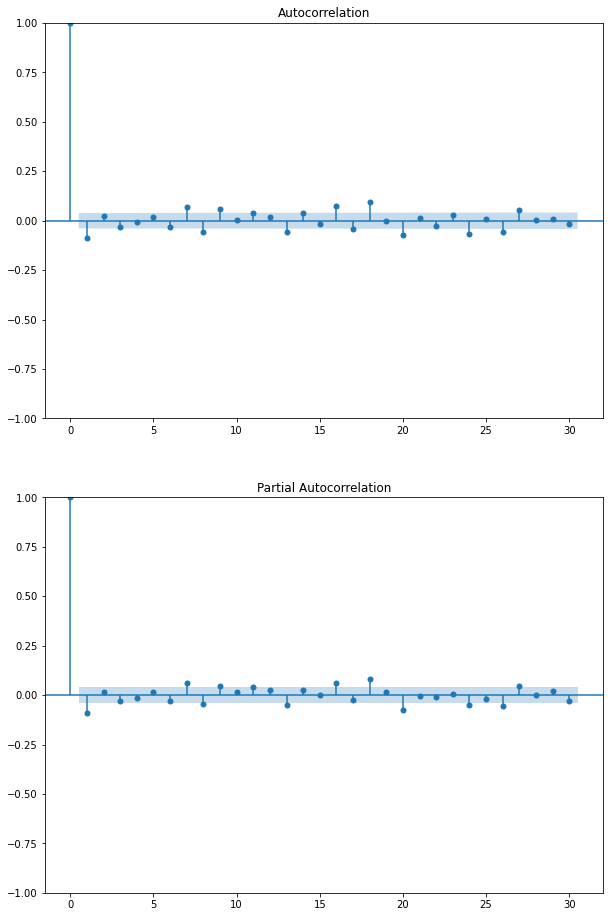

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,16))
diff = df_close.diff().dropna()
#ACF plot
plot_acf(diff, lags=30, ax=ax[0]);
#PACF plot
plot_pacf(diff, lags=30, method='ywm', ax=ax[1]);

p = 2 , d = 1 , q = 2 

In [139]:
from statsmodels.tsa.arima.model import ARIMA

train_df = df_close[:2337]
test_df = df_close[2337:]

arima_model = ARIMA(train_df, order=(3,1,3))
result = arima_model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2337
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3464.603
Date:                Thu, 13 Jan 2022   AIC                           6943.206
Time:                        21:11:16   BIC                           6983.500
Sample:                             0   HQIC                          6957.885
                               - 2337                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8713      0.004   -247.268      0.000      -0.878      -0.864
ar.L2          0.8771      0.006    156.009      0.000       0.866       0.888
ar.L3          0.9929      0.004    275.922      0.0

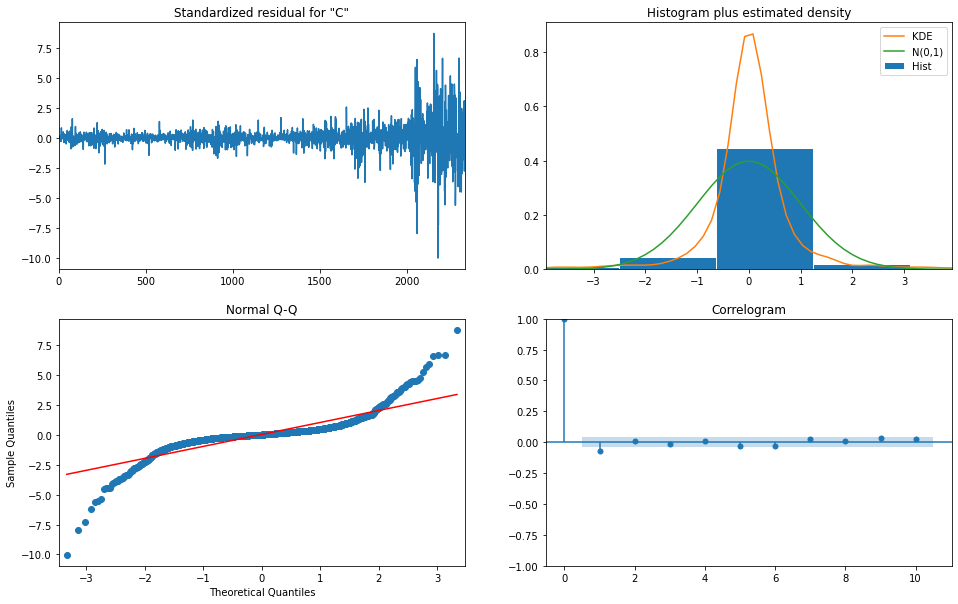

In [140]:
result.plot_diagnostics(figsize=(16,10));

In [141]:
date = pd.date_range(start='19-04-2021', end='31-12-2021', freq='d')
pred = result.forecast(len(date))
df_pred = pred.to_frame(name='Predicted').set_index(date)
df_pred.head(10)

,Predicted
2021-04-19,133.580158
2021-04-20,134.359074
2021-04-21,133.913248
2021-04-22,134.409125
2021-04-23,134.359445
2021-04-24,134.394980
2021-04-25,134.812814
2021-04-26,134.430589
2021-04-27,135.165382
2021-04-28,134.604786


In [142]:
df_pred.insert(loc=0, column='Actual', value=test_df)
df_pred.dropna(inplace=True)

In [143]:
df_pred

,Actual,Predicted
2021-04-19,134.839996,133.580158
2021-04-20,133.110001,134.359074
2021-04-21,133.500000,133.913248
2021-04-22,131.940002,134.409125
2021-04-23,134.320007,134.359445
...,...,...
2021-12-27,180.330002,161.061395
2021-12-28,179.289993,161.314949
2021-12-29,179.380005,161.365451
2021-12-30,178.199997,161.418846


In [144]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_pred.index,
                         y=df_pred.Actual,
                         mode='lines',
                         name='Actual'))
                         
fig.add_trace(go.Scatter(x=df_pred.index,
                         y=df_pred.Predicted,
                         mode='lines',
                         name='Predicted'))

fig.update_layout(height=600, width=960)
fig.show()

In [133]:
from pmdarima.arima import auto_arima

auto_arm = auto_arima(train_df, start_p=3, d=1, start_q=3,
                      max_p=3, max_d=2, max_q=4, 
                      trace=True,
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=False,
                      seasonal = False,
                      out_of_sample_size = 180,
                      scoring = 'mse',
                      with_intercept=False,
                      n_fits=50)

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7027.522, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7003.839, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7002.835, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=7004.401, Time=0.45 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=7006.162, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7002.208, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7002.380, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=7006.493, Time=0.99 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=7006.283, Time=0.68 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=7006.678, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7002.478, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7004.249, Time=0.79 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7006.375, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6944.587, Time=1.93 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7004.328, Time=0.33 sec
 ARIMA(3,1

In [122]:
auto_arm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2337
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3466.294
Date:                Thu, 13 Jan 2022   AIC                           6944.587
Time:                        20:43:54   BIC                           6979.125
Sample:                             0   HQIC                          6957.169
                               - 2337                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8559      0.005   -370.780      0.000      -1.866      -1.846
ar.L2         -0.9761      0.005   -197.618      0.000      -0.986      -0.966
ma.L1          1.7707      0.010    178.229      0.000       1.751       1.790
ma.L2          0.8294      0.017     49.316      0.000       0.796       0.862
ma.L3         -0.0589      0.010     -5.985      0.000      -0.078      -0.040
sigma2         1.1490      0.011    102.434      0.000       1.127       1.171
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             34277.92
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              25.51   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""